In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from sys import argv
# import import_ipynb #Allows you to import ipynb files

from pathfinder import *

In [43]:
def get_obs_ranges(block_width, block_height, blocks,spacer):
    obs_x = []
    obs_y = []
    for x in range(blocks[1]):
        start = block_width*x + spacer*x
        end = start + block_width
        obs_x.append((start,end))
    for y in range(blocks[0]):
        start = block_height*y + spacer*y
        end = start + block_height
        obs_y.append((start,end))
    return [obs_x,obs_y]

def get_obs_coordinates(x_ranges, y_ranges,spacer):
    obs = []
    free_space_ranges_x = set()
    free_space_ranges_y = set()
    for x_range in x_ranges:
        free_space_ranges_x.add((int(x_range[1])+2, int(x_range[1])+spacer-2 ))
        for y_range in y_ranges:
            free_space_ranges_y.add((int(y_range[1])+2, int(y_range[1])+spacer-2 ))
            for x in range(int(x_range[0]), 1+int(x_range[1]) ):
                obs.append((x,int(y_range[0])))
                obs.append((x,int(y_range[1])))
            for y in range(int(y_range[0]), int(y_range[1]) ):
                obs.append((int(x_range[0]),y))
                obs.append((int(x_range[1]),y))
    free_space_ranges_x.remove((int(x_ranges[-1][1]+2), int(x_ranges[-1][1])+spacer-2))
    free_space_ranges_y.remove((int(y_ranges[-1][1])+2, int(y_ranges[-1][1])+spacer-2 ))
    return [obs,free_space_ranges_x,free_space_ranges_y]

def get_streets_intersections(free_space_ranges_x,free_space_ranges_y,block_height,block_width):
    streets = set()
    intersections = set()
    for x in free_space_ranges_x:
        for y in free_space_ranges_y:
            street_bottom = (y[0]-block_height-2,y[0]-2)
            street_top = (y[1]+2,y[1]+block_height+2)
            
            street_left = (x[0]-block_width-2,x[0]-2)
            street_right = (x[1]+2,x[1]+block_width+2)
            
            
            intersections.add((x,y))
            streets.add((x,street_bottom))
            streets.add((x,street_top))
            streets.add((street_right,y))
            streets.add((street_left,y))
    return [streets, intersections]

def get_start_end_points(free_space_ranges_x,rows):
    x_range1 = random.choice(tuple(free_space_ranges_x))
    free_space_ranges_x.remove(x_range1)
    x_range1 = np.arange(x_range1[0],x_range1[1])
    
    x_range2 = random.choice(tuple(free_space_ranges_x))
    x_range2 = np.arange(x_range2[0],x_range2[1])
    
    y_range = np.arange(1,rows)
    
    x_start = random.choice(x_range1)
    y_start = random.choice(y_range)
    
    x_end = random.choice(x_range2)
    y_end = random.choice(y_range)
    
    orientations = np.arange(0,369)
    start_o = random.choice(orientations)
    end_o = random.choice(orientations)
    
    return [(x_start,y_start,start_o),(x_end,y_end,end_o)]
       
def map_generate(rows,cols,blocks,spacer):
    col_space = cols - (blocks[1]-1)*spacer
    row_space = rows - (blocks[0]-1)*spacer
    block_width = col_space/blocks[1]
    block_height = row_space/blocks[0]
    x_ranges, y_ranges = get_obs_ranges(block_width,block_height,blocks,spacer)
    obs, free_space_ranges_x,free_space_ranges_y = get_obs_coordinates(x_ranges, y_ranges,spacer)
    streets,intersections = get_streets_intersections(free_space_ranges_x,free_space_ranges_y,int(block_height),int(block_width))
    start,end = get_start_end_points(free_space_ranges_x,rows)
    return [obs,start,end,streets,intersections]

def path_generate(g,rows,cols,blocks,obstacle_list,start_p,end_p):
    v = Vehicle((1,1), velocity=1)
    [g.AddObstacle(obs) for obs in obstacle_list]
    
    start = VehicleState((start_p[0],start_p[1]),np.deg2rad(start_p[2]))
    end = VehicleState((end_p[0],end_p[1]),np.deg2rad(end_p[2]))

    hastar = HybridAStar(g, v)
    path, states = hastar.run(start,end)
        
    return [path,states,start,end]

In [44]:
def display_obstacles(obstacle_list,ax):
    obs_X = [cell[0] for cell in obstacle_list]
    obs_Y = [cell[1] for cell in obstacle_list]
    ax.plot(obs_X, obs_Y, marker='*', color='black', MarkerSize=15, linestyle='none')

def display_streets(streets,ax):
    for i in streets:
        line1 = [[i[0][0],i[0][0]],[i[1][0],i[1][1]] ]
        line2 = [[i[0][1],i[0][1]],[i[1][0],i[1][1]] ]
        line3 = [[i[0][0],i[0][1]],[i[1][0],i[1][0]] ]
        line4 = [[i[0][0],i[0][1]],[i[1][1],i[1][1]] ]
        ax.plot(line1[0], line1[1], linestyle='solid', color='red')
        ax.plot(line2[0], line2[1], linestyle='solid', color='red')
        ax.plot(line3[0], line3[1], linestyle='solid', color='red')
        ax.plot(line4[0], line4[1], linestyle='solid', color='red')

def display_path(path,states,start,end,ax):
    path_X = [cell[0] for cell in path] 
    path_Y = [cell[1] for cell in path]
    
    state_X = [state.position[0] for state in states] 
    state_Y = [state.position[1] for state in states]
    state_O = [state.orientation for state in states]
    
    ax.plot(start.position[0], start.position[1], marker='.', color='green', linestyle='none', MarkerSize=40)
    x, y, a, b = start.position[0], start.position[1], 1, np.rad2deg(start.orientation)
    x1, y1 = rpoint(x,y,a,b)
    ax.arrow(x, y, (x1-x)/2, (y1-y)/2, head_width = .4, width = .1,color='green')
    ax.plot(end.position[0], end.position[1], marker='.', color='red', linestyle='none', MarkerSize=40)
    x, y, a, b = end.position[0], end.position[1], 1, np.rad2deg(end.orientation)
    x1, y1 = rpoint(x,y,a,b)
    ax.arrow(x, y, (x1-x)/2, (y1-y)/2, head_width = .4, width = .1,color='red')
    
    ax.plot(state_X, state_Y, marker='*', color='purple', MarkerSize=10)
    
    for index in range(len(state_O)):
        x, y, a, b = state_X[index], state_Y[index], 1, np.rad2deg(state_O[index])
        x1, y1 = rpoint(x,y,a,b)
        ax.arrow(x, y, (x1-x)/2, (y1-y)/2, head_width = .5, width = .1,)

    

NO PATH FOUND


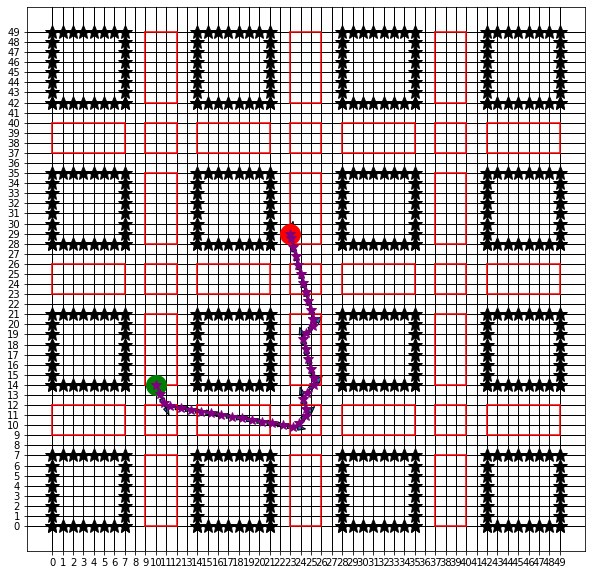

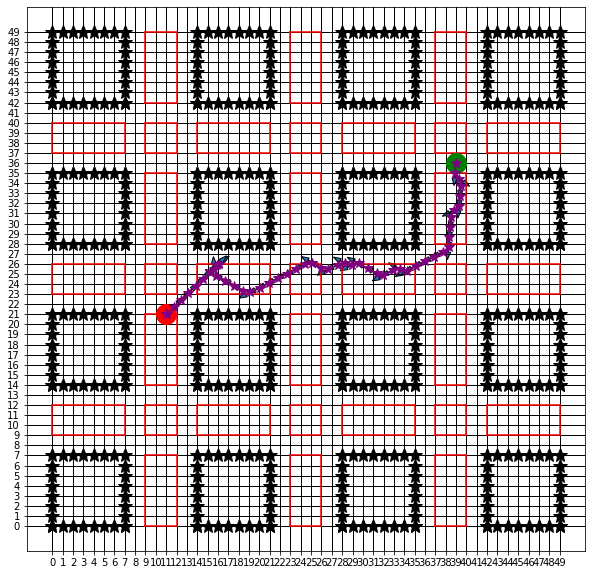

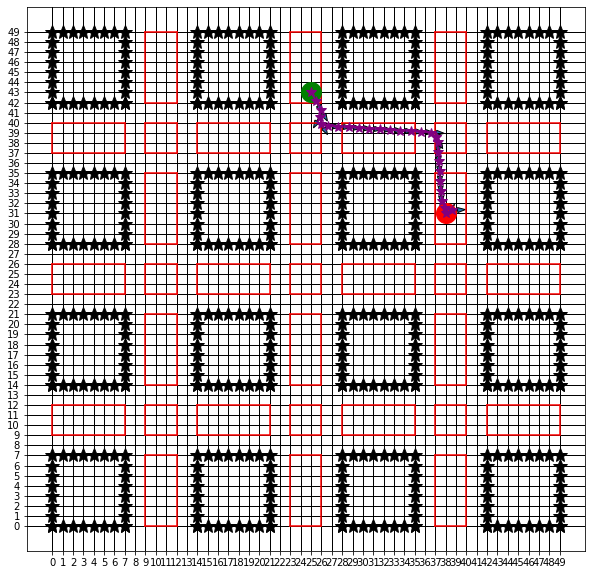

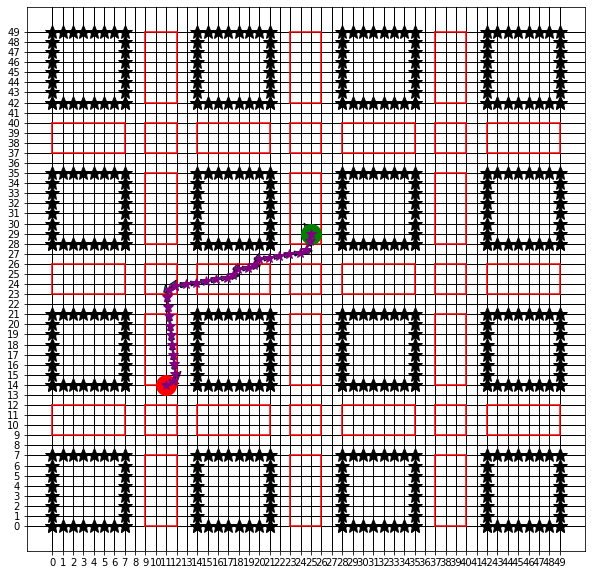

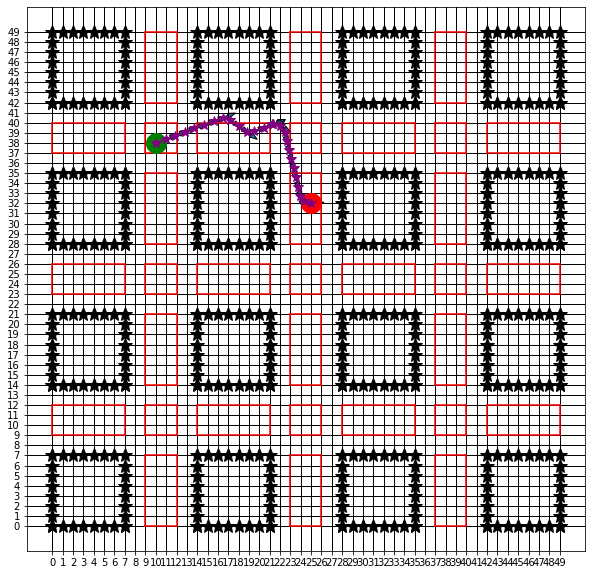

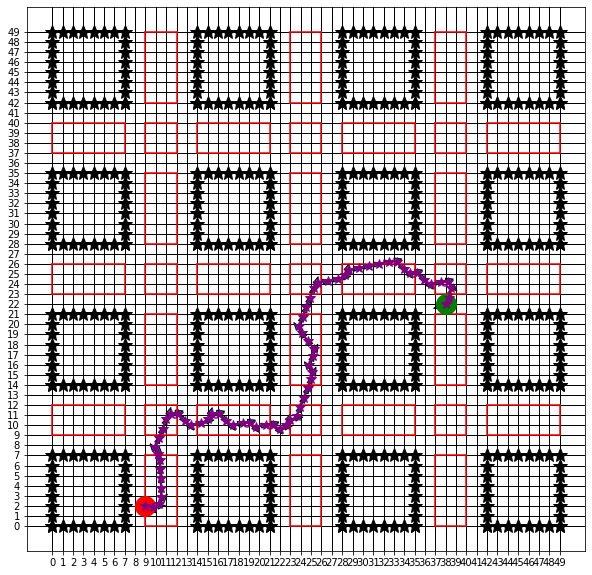

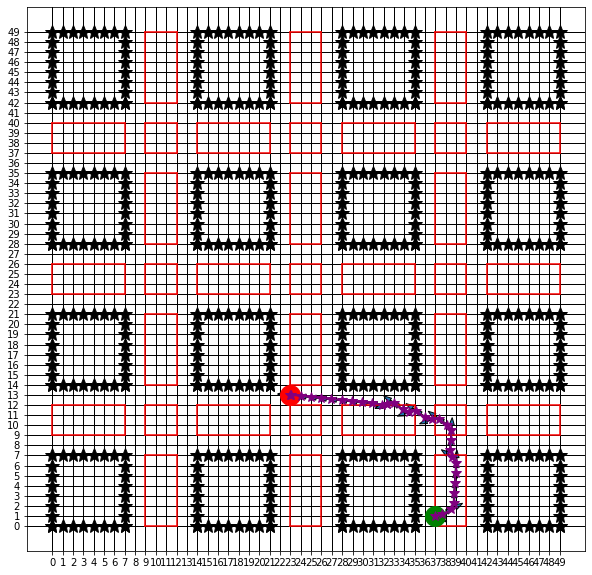

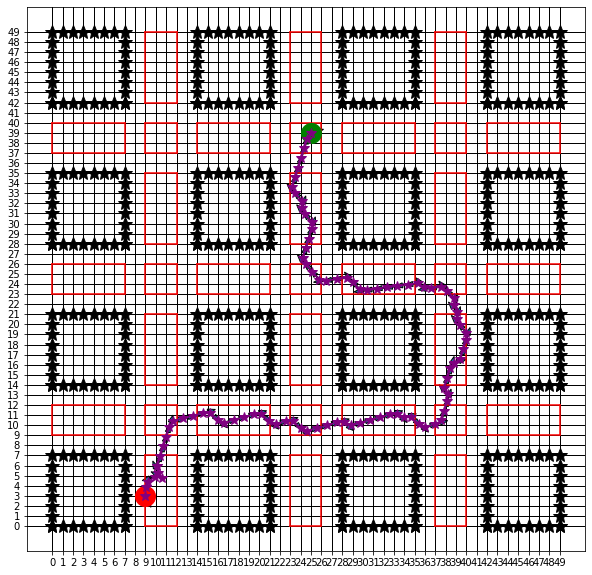

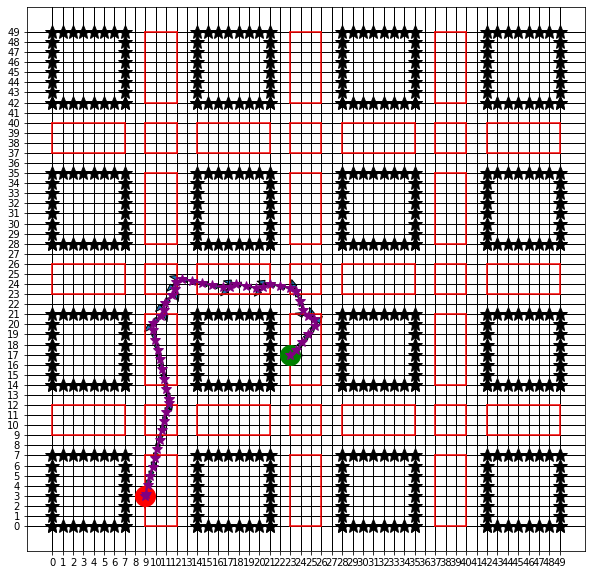

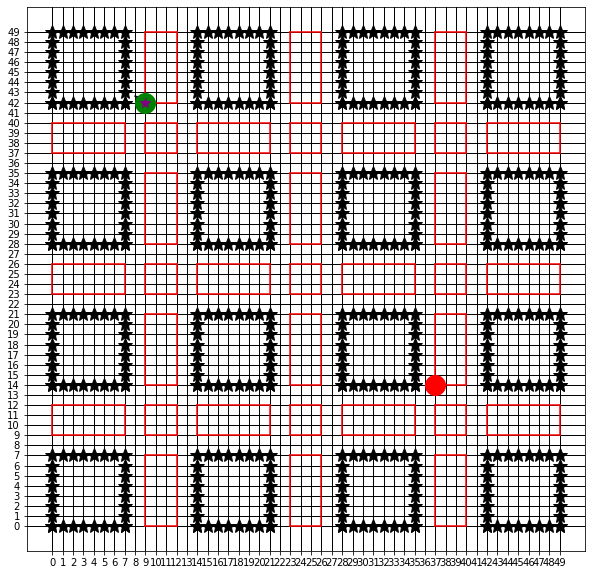

In [47]:

rows, cols = 50, 50
blocks = [4,4]
plt.rcParams['figure.figsize'] = [10, 10]
for i in range(10):
    g = Grid(rows, cols)
    fig, ax = plt.subplots()
    obstacle_list,start,end,streets,intersections = map_generate(rows-1,cols-1,blocks,7)
    path,states,start,end = path_generate(g,rows,cols,blocks,obstacle_list,start,end)
    display_streets(streets,ax)
    display_streets(intersections,ax)
    display_obstacles(obstacle_list,ax)
    display_path(path,states,start,end,ax)
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
    ax.set_xticks(np.arange(0, rows, 1))
    ax.set_yticks(np.arange(0, cols, 1))
    
plt.show()
   
    
    




